# Correlations for CANA, PID, and ECA dynamics
## Load and combine data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

boolmin = pd.read_csv('../data/eca_decompositions/canalization_df.csv')
imin = pd.read_csv('../data/eca_decompositions/imin_df.csv', index_col=0)
dynamics = pd.read_csv('../data/eca_simple_dynamics.csv', index_col=0)
classes = pd.read_csv('../data/eca_equiv_classes.csv', index_col=0)

### Combine data into one big ol' dataframe

In [29]:
n_cells = 16
dyn_cells = dynamics[dynamics['n_cells'] == n_cells]
df0 = boolmin.merge(dyn_cells, on='rule')
df1 = df0.merge(imin, on='rule')
df = df1.merge(classes, on='rule')
df['ke'] = 1 - df['kr*']
df.columns

Index(['rule', 'kr*', 'ks*', 'r(0)', 'r(1)', 'r(2)', 's(0)', 's(1)', 's(2)',
       'n_cells', 'm_attractors', 'max_period', 'max_transient',
       'derrida_coeff', 'transient_to_attractor', '((0,), (1,), (2,))',
       '((0,), (1,))', '((0,), (2,))', '((0,), (1, 2))', '((0,),)',
       '((1,), (2,))', '((1,), (0, 2))', '((2,), (0, 1))',
       '((0, 1), (0, 2), (1, 2))', '((0, 1), (0, 2))', '((1,),)',
       '((0, 1), (1, 2))', '((0, 1),)', '((2,),)', '((0, 2), (1, 2))',
       '((0, 2),)', '((1, 2),)', '((0, 1, 2),)', 'wclass', 'ke'],
      dtype='object')

## Check relationships between effective connectivity and dynamics
We expect Derrida coefficient to increase with $k_e$. We expect transient length and/or number of attractors to indicate a lack of stability and therefor increase with $k_e$ as well.

### Dynamics Measurements
- Number of Attractors $(|\mathcal{A}|)$
- Max period of attractor $(\max{T})$
- Max transient length $(\max{\sigma(\textbf{x})})$
- Ratio of transient states to attractor states $(\frac{|\Sigma(\textbf{x})|}{|a| \in \mathcal{A}})$
- derrida Coefficient $(D_c)$

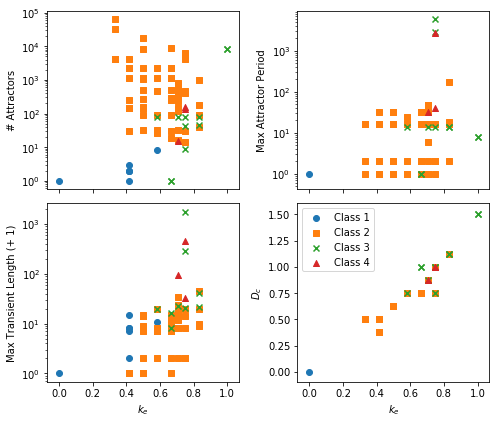

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7, 6))
shapes = ['_', 'o', 's', 'x', '^']

# attractors vs. effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 0].scatter(df_class['ke'], df_class['m_attractors'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel(r'# Attractors')

# max period vs. effective conectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 1].scatter(df_class['ke'], df_class['max_period'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel(r'Max Attractor Period')

# transient ratio vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 0].scatter(df_class['ke'], df_class['max_transient'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel(r'$k_e$')
ax[1, 0].set_ylabel(r'Max Transient Length (+ 1)')

# derrida vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 1].scatter(df_class['ke'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 1].legend()
ax[1, 1].set_xlabel(r'$k_e$')
ax[1, 1].set_ylabel(r'$D_c$')

plt.tight_layout()
plt.show()

Let's try this a different way, the overplotting is really bad

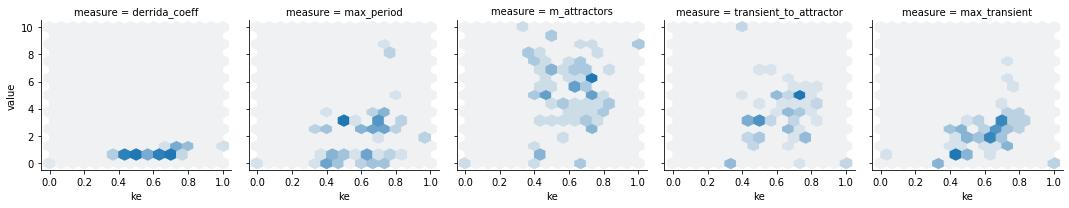

In [100]:
# get a smaller dataframe and set it up for plotting on a facet grid
# a bunch of this code is a waste of time but im going to keep it for now
df_ke = df[['m_attractors', 'max_period', 'max_transient', 'transient_to_attractor', 'derrida_coeff', 'ke', 'ks*', 'rule', 'wclass']]
df_ke['max_transient'] = np.log(df_ke['max_transient'] + 1)
df_ke['transient_to_attractor'] = np.log(df_ke['transient_to_attractor'] + 1)
df_ke['m_attractors'] = np.log(df_ke['m_attractors'])
df_ke['max_period'] = np.log(df_ke['max_period'])
df_ke['derrida_coeff'] = df_ke['derrida_coeff']
df_long = pd.melt(df_ke, id_vars=['rule', 'ke', 'ks*', 'wclass'], value_vars=['derrida_coeff', 'max_period', 'm_attractors', 'transient_to_attractor',     
                  'max_transient'], var_name='measure')

# from the seaborn docs
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

# now set up a FacetGrid
g = sns.FacetGrid(df_long, col='measure')
g.map(hexbin, 'ke', 'value', extent=[0, 1, 0, 10])
plt.show()

Derrida Looks really bad there but in general I think the point comes across well enough for now.

Let's look at correlation coefficients to see if there are any strong relationships we're missing in the cloud of points:

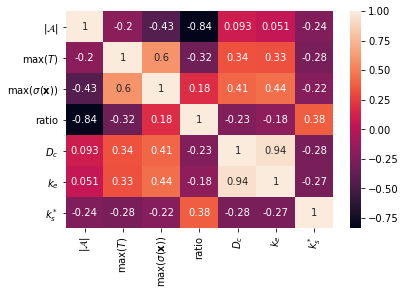

In [101]:
nice_labels = [r'$|\mathcal{A}|$', r'$\max{(T)}$', r'$\max{(\sigma{(\mathbf{x})})}$', r'ratio', r'$D_c$', r'$k_e$', r'$k_s^*$']
sns.heatmap(df_ke.drop(['rule', 'wclass'], axis=1).corr(), annot=True, xticklabels=nice_labels, yticklabels=nice_labels)

So we can see many of the same patterns we saw in the scatter plots. Strong correlation with Derrida Coefficient and moderate correlation with attractor and period length. Interestingly, Input symmetry correlates moderately with transient to attractor ratio. We will look at each of these input symmetry patterns below.

## Input Symmetry and Dynamics
We'll make the same grid of plots with $k_S^*$ on the x-axis I dont think we expect much from this but we might find something!

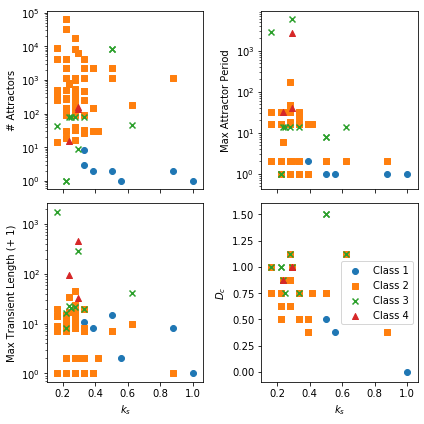

In [102]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(7, 6))
shapes = ['_', 'o', 's', 'x', '^']

# attractors vs. effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 0].scatter(df_class['ks*'], df_class['m_attractors'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel(r'# Attractors')

# max period vs. effective conectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 1].scatter(df_class['ks*'], df_class['max_period'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel(r'Max Attractor Period')

# transient ratio vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 0].scatter(df_class['ks*'], df_class['max_transient'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 0].set_yscale('log')
ax[1, 0].set_xlabel(r'$k_s$')
ax[1, 0].set_ylabel(r'Max Transient Length (+ 1)')

# derrida vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 1].scatter(df_class['ks*'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 1].legend()
ax[1, 1].set_xlabel(r'$k_s$')
ax[1, 1].set_ylabel(r'$D_c$')

plt.tight_layout()
plt.show()

So we have correlation but it is not obvious

## PI atoms and Derrida Coefficient.
The derrida coefficient showed the strongest trend so we'll start with that.

To begin, we'll only consider a few PI atoms.
- $\{0\}\{1\}\{2\}$ - Shared information between all inputs
- $\{0, 1, 2\}$ - Synergistic information between all three inputs
- Total Unique - Unique information from input one
- Synergy Bias - difference between the sum of all "synergistic" atoms and all "shared" atoms

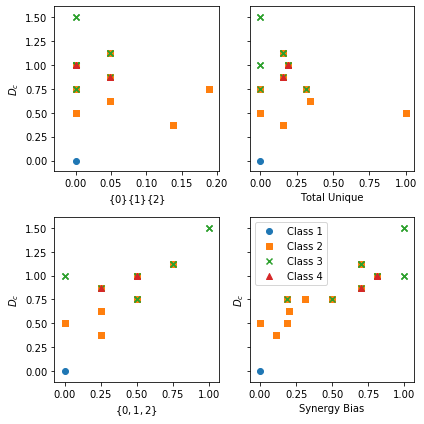

In [104]:
# synergy bias
df['syn_sum'] = df[['((0, 1, 2),)', '((0, 1),)', '((0, 2),)', '((1, 2),)', '((0, 2), (1, 2))', '((0, 1), (1, 2))', '((0, 1), (0, 2))']].sum(axis=1) 
df['sha_sum'] = df[['((0,), (1,), (2,))', '((0,), (1,))', '((0,), (2,))', '((0,), (1, 2))','((1,), (2,))', '((1,), (0, 2))', '((2,), (0, 1))',]].sum(axis=1)
df['syn-sha'] = df['syn_sum'] - df['sha_sum']

# neither synergy nor redundancy
df['unq_sum'] = df[['((0,),)', '((1,),)', '((2,),)', '((0, 1), (0, 2), (1, 2))']].sum(axis=1)

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(7, 6))
shapes = ['_', 'o', 's', 'x', '^']

# attractors vs. effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 0].scatter(df_class['((0,), (1,), (2,))'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 0].set_xlabel(r'$\{0\}\{1\}\{2\}$')
ax[0, 0].set_ylabel(r'$D_c$')

# max period vs. effective conectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[0, 1].scatter(df_class['unq_sum'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[0, 1].set_xlabel(r'Total Unique')

# transient ratio vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 0].scatter(df_class['((0, 1, 2),)'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 0].set_xlabel(r'$\{0, 1, 2\}$')
ax[1, 0].set_ylabel(r'$D_c$')

# derrida vs effective connectivity
for cl in range(1, 5):
    df_class = df[df['wclass'] == cl]
    ax[1, 1].scatter(df_class['syn-sha'], df_class['derrida_coeff'], label='Class {}'.format(cl), marker=shapes[cl])

ax[1, 1].legend()
ax[1, 1].set_xlabel(r'Synergy Bias')
ax[1, 1].set_ylabel(r'$D_c$')

plt.tight_layout()
plt.show()

Looks like strong correlations in full synergy and synergy bias. In the sense of synergy bias it looks like shared information and redundancy do produce similar results. Again there is surely alot of overplotting going on so let's look at some histograms.

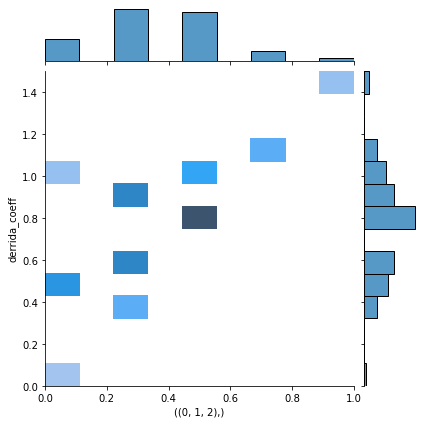

In [95]:
g = sns.JointGrid(data=df, x='((0, 1, 2),)', y='derrida_coeff')
g.plot(sns.histplot, sns.histplot)

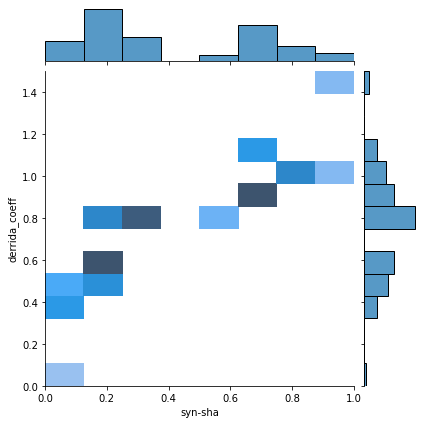

In [96]:
g = sns.JointGrid(data=df, x='syn-sha', y='derrida_coeff')
g.plot(sns.histplot, sns.histplot)

These still look like solid correlations. Let's check them.

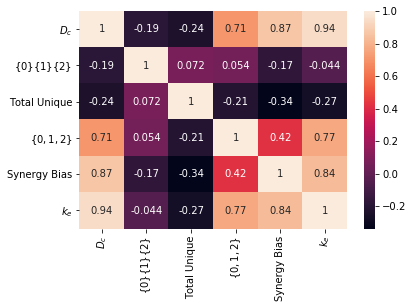

In [114]:
df_info_corr = df[['derrida_coeff', '((0,), (1,), (2,))', 'unq_sum', '((0, 1, 2),)', 'syn-sha', 'ke']]
nice_labels = [r'$D_c$', r'$\{0\}\{1\}\{2\}$', r'Total Unique', r'$\{0, 1, 2\}$', r'Synergy Bias', r'$k_e$']
sns.heatmap(df_info_corr.corr(), annot=True, xticklabels=nice_labels, yticklabels=nice_labels)

We see a strong correlation between synergy bias and derrida coefficient as expected. This implies the strong correlation between synergy bias and $k_e$ that we see as well. Let's take a look at that relationship. There will be massive overplotting here so again we'll turn to histograms.

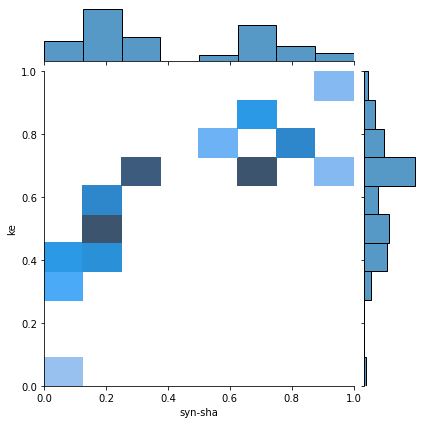

In [119]:
g = sns.JointGrid(data=df, x='syn-sha', y='ke')
g.plot(sns.histplot, sns.histplot)

Looks like a sensible correlation. We can also consider the rest of our dynamics measures.

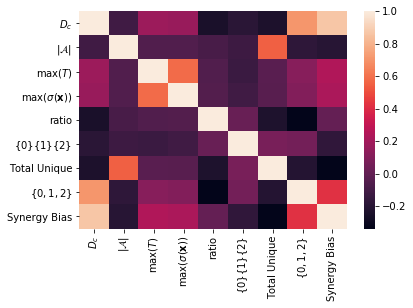

In [116]:
df_info_corr = df[['derrida_coeff', 'm_attractors', 'max_period', 'max_transient', 'transient_to_attractor', '((0,), (1,), (2,))', 'unq_sum', '((0, 1, 2),)', 'syn-sha']]
nice_labels = [r'$D_c$', r'$|\mathcal{A}|$', r'$\max{(T)}$', r'$\max{(\sigma{(\mathbf{x})})}$', r'ratio', r'$\{0\}\{1\}\{2\}$', r'Total Unique', r'$\{0, 1, 2\}$', r'Synergy Bias']
sns.heatmap(df_info_corr.corr(), xticklabels=nice_labels, yticklabels=nice_labels)

We see correlation between unique information and the number of attractors as well as moderate correlation between synergy bias and the max period as well as transient length